[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Farhad-Davaripour/Linear_regression_Core_Principles/blob/main/demo.ipynb)

# Build Your Polynomial Regression Model

## Dependencies

In [1]:
from typing import Optional, Tuple # used to define function signature.
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression # used to generate synthetic data.
from IPython.display import clear_output # used to delete the output after each iteration of the loop.
import time # used to set a pause before the following iteration in the loop.
%matplotlib inline

## Engine
The Value class define all the components used in feeding forward (calculting the mathematical expression for linear regression) and for backpropagateion (calculating the derivative of the loss function with respect to the model parameters). The Value class is originally developed as a part of [micrograd project](https://github.com/karpathy/micrograd) by [Andrej Karpathy](https://github.com/karpathy) and updated to be used for linear regression.

In [2]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda :None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+', label=f'({self.label}+{other.label})')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*', label=f'({self.label}*{other.label})')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}', label=f'({self.label}**{other})')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []

        def build_topo(v):
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        negated_value = Value(-self.data, _children=(self,), _op='neg', label=f'(-{self.label})')
        def _backward():
            self.grad -= negated_value.grad
        negated_value._backward = _backward
        return negated_value

    def __radd__(self, other): # other + self
        if other == 0:
          return self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, label='{self.label}')" if self.label else f"Value(data={self.data}, grad={self.grad})"

## Hypothesis Class
Define the mathematical expression for linear regression algorithm: y = x * w + b

In [3]:
class Hypothesis:
    def __init__(self, nin, order=1):
        self.order = order
        # Adjust number of weights. Note: We start weights from order 1 as order 0 is handled by bias
        self.w = [[Value(random.uniform(-1, 1), label=f'w_{i+1}^{j}') for j in range(1, order + 1)] for i in range(nin)]
        self.b = Value(0, label='bias')

    def __call__(self, x):
        # Start with the bias term
        act = self.b
        # Iterate over each feature's weights, skipping the bias term in the polynomial terms
        for xi, wi in zip(x, self.w):
            for j, w_ij in enumerate(wi, start=1):  # Start enumeration at 1 to align with polynomial order
                act += w_ij * Value(xi.data ** j, label=f'{xi.label}^{j}')
        return act

    def parameters(self):
        # Flatten the list of weights and include the bias
        return [w_ij for wi in self.w for w_ij in wi] + [self.b]

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def __repr__(self):
        return f"Hypothesis function with {len(self.parameters())} parameters"

## Graph Visualization
A graph visualization to observe the results of feed forward and backpropagation operations.

In [4]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    Draws a graph of the computational graph of a `Value` object.
    """
    assert rankdir in ['LR', 'TB'], "rankdir must be 'LR' or 'TB'"
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})

    for n in nodes:
        # Node label includes the operation, value, and gradient
        node_label = f"{n.label}: {n.data:.4f} | grad: {n.grad:.4f}" if n.label else f"data: {n.data:.4f} | grad: {n.grad:.4f}"
        dot.node(name=str(id(n)), label=node_label, shape='record')

        if n._op:
            # Operation node
            op_label = f"{n._op}" if n.label else n._op
            dot.node(name=str(id(n)) + n._op, label=op_label, shape='ellipse')
            # Edge from operation to the resulting value
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        # Edge from operand to the operation node
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Visualizing the Optimization
This plot shows the polynomial fit to the data, during the iterative numerical (Gradient Descent) optimization.

In [74]:
def visualize(order=3):
    # Generate predictions across the range of X values for visualization
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = np.array(y).min() - 1, np.array(y).max() + 1  # Convert 'y' to numpy array
    
    xx = np.linspace(x_min, x_max, 1000)  # More points for a smoother curve
    
    # Create polynomial features for the xx values
    xx_poly = np.array([[x_i] for x_i in xx])
    
    # Prepare inputs for the model
    inputs = [list(map(lambda x: Value(x, label=f'input_{i+1}'), xrow)) for i, xrow in enumerate(xx_poly)]
    
    # Generate predictions
    scores = list(map(model, inputs))
    predictions = np.array([score.data for score in scores])
    
    # Plot the data points
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], y, color='blue', label='Data Points')
    
    # Plot the polynomial regression curve
    plt.plot(xx, predictions, color='red', label='Polynomial Regression Curve')
    
    # Set plot labels and title
    plt.xlabel('Input Feature')
    plt.ylabel('Target Value')
    plt.title(f'{order}th Order Polynomial Regression Fit')
    plt.legend(loc='upper left')
    
    # Fix the axis range
    plt.xlim(x_min, x_max)
    plt.ylim(y_min - 10, y_max + 10)
    plt.show()

## Generate Synthetic Data
For simplicity synthetic data with only one input feature is generated.

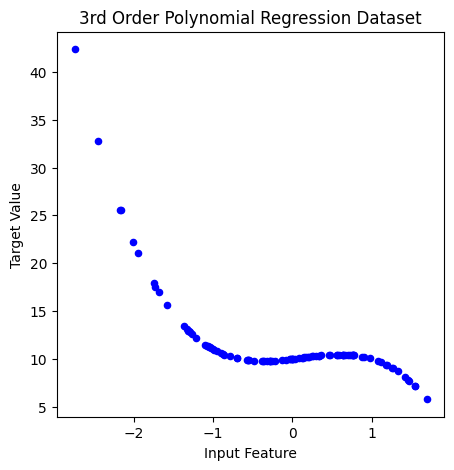

In [60]:
# Set the random seed for reproducibility
np.random.seed(1337)
random.seed(1337)

# Generate a regression dataset with a single feature
X, _ = make_regression(n_samples=100, n_features=1, noise=10)

# Generate higher-order features (2nd and 3rd order)
X_2 = X**2
X_3 = X**3

# Define coefficients for the 3rd order polynomial and bias
w1, w2, w3, bias = 1, 0.5, -1.5, 10

# Compute the target values using the 3rd order polynomial equation
y = w1*X.flatten() + w2*X_2.flatten() + w3*X_3.flatten() + bias

# Visualize the dataset in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X, y, c='blue', s=20)  # Color doesn't represent classes, just for visualization
plt.xlabel('Input Feature')
plt.ylabel('Target Value')
plt.title('3rd Order Polynomial Regression Dataset')
plt.show()


## Define/Implement Loss Function
Mean squared error is defined as the lost function to quanify the error in the model prediction.

In [87]:
# set the number of inputs
n_inputs = 1
order = 3
model = Hypothesis(n_inputs, 3)

def loss(batch_size: Optional[int] = None)-> Tuple[np.ndarray, np.ndarray, Value]:

    """ Computes the loss for a batch of examples using Mean Squared Error and L2 regularization.
    If batch_size is None, the entire dataset is used. """

    # set the random seed
    np.random.seed(1337)
    random.seed(1337)

    # Randomly sample batch_size examples from the dataset
    ri = np.random.permutation(X.shape[0])[:batch_size]
    Xb, yb = X[ri], y[ri]
    inputs = [list(map(lambda x: Value(x, label=f'input_{i+1}'), xrow)) for i, xrow in enumerate(Xb)]

    # Forward the model to get scores (predictions)
    scores = list(map(model, inputs))

    # Mean Squared Error loss
    losses = [(Value(yi, label=f'target_{i+1}') - scorei) ** 2 for i, (yi, scorei) in enumerate(zip(yb, scores))]
    data_loss = sum(losses) / Value(len(losses), label='n_inputs')

    # L2 regularization
    alpha = 1e-4
    reg_loss = Value(alpha, label = 'alpha') * sum((Value(p.data ** 2, label=f'L2_reg_{i+1}') for i, p in enumerate(model.parameters()) if 'bias' not in p.label))
    total_loss = data_loss  + reg_loss
    total_loss.label = 'total_loss'  # Label the total_loss node

    return Xb, yb, total_loss

## Visualize a Simple Graph
A graph is generated to illustrate the feed forward and backpropagate operation.

The loss value: 277.2968 with model parameters = w_1^1: 0.24., w_1^2: 0.07., w_1^3: -0.27., bias: 0.


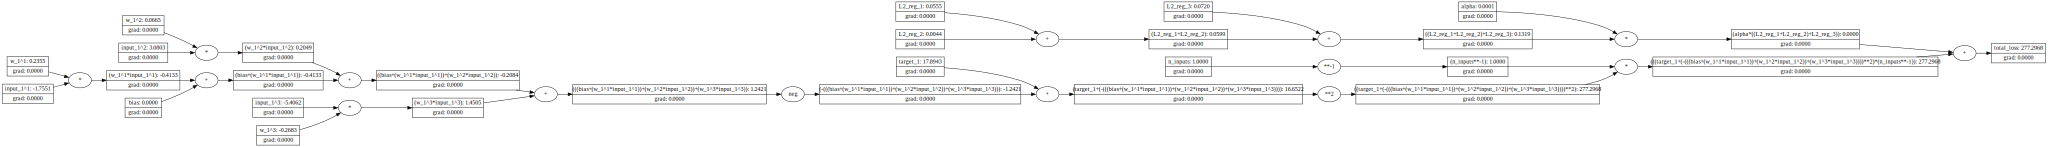

In [88]:
Xb, yb, total_loss = loss(1)
model.zero_grad()

print(f"The loss value: {round(total_loss.data,4)} with model parameters = " + ", ".join([f"{p.label}: {round(p.data,2)}." for p in model.parameters()]))

draw_dot(total_loss)

## Numerical optimization
Define/Implement Gradient Descent: Gradient descent (GD) is a popular technique to update model parameters based on the gradients of the loss function with respect to each parameter of the model. The optimization speed could be adjusted by fine tuning the learning rate. Using a large learning rate could work in opposite and make the process increase the loss.

In [116]:
# reset the parameter value
for p in model.parameters():
    p.data = 0.1

# optimization
param = []
losses = []

for k in range(1000):

    # forward
    Xb, yb, total_loss = loss()

    # backward
    model.zero_grad()
    total_loss.backward()
    losses.append(total_loss.data)

    learning_rate = 0.04 / (1 + 0.01 * k)  # Decreasing learning rate schedule
    for p in model.parameters():
      if 'w_1^1' in p.label:
        param.append(p.data)
        p.data -= learning_rate * p.grad
      else:
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        clear_output(wait=True)  # Clear the previous plot
        w1, w2, w3, bias 
        print(f"actual parameters: w1 = {w1}, w2 = {w2}, w3 = {w3}, bias = {bias}")
        print(f"step {k+1}, loss = {total_loss.data}, with GD parameters = " + ", ".join([f"{p.label}: {round(p.data,2)}" for p in model.parameters()]))
        visualize(order=3)  # Vis function to plot the data and regression line
        time.sleep(0.2)  # Pause a bit to see the plot before it gets cleared

actual parameters: w1 = 1, w2 = 0.5, w3 = -1.5, bias = 10
step 1000, loss = 0.0009000527457181694, with GD parameters = w_1^1: 0.97, w_1^2: 0.52, w_1^3: -1.49, bias: 9.98


## Visualize the Convergence
This plot shows the value of the model parameter during the optimization. Based on the magnitude of the learning rate, the curve could noteably change.

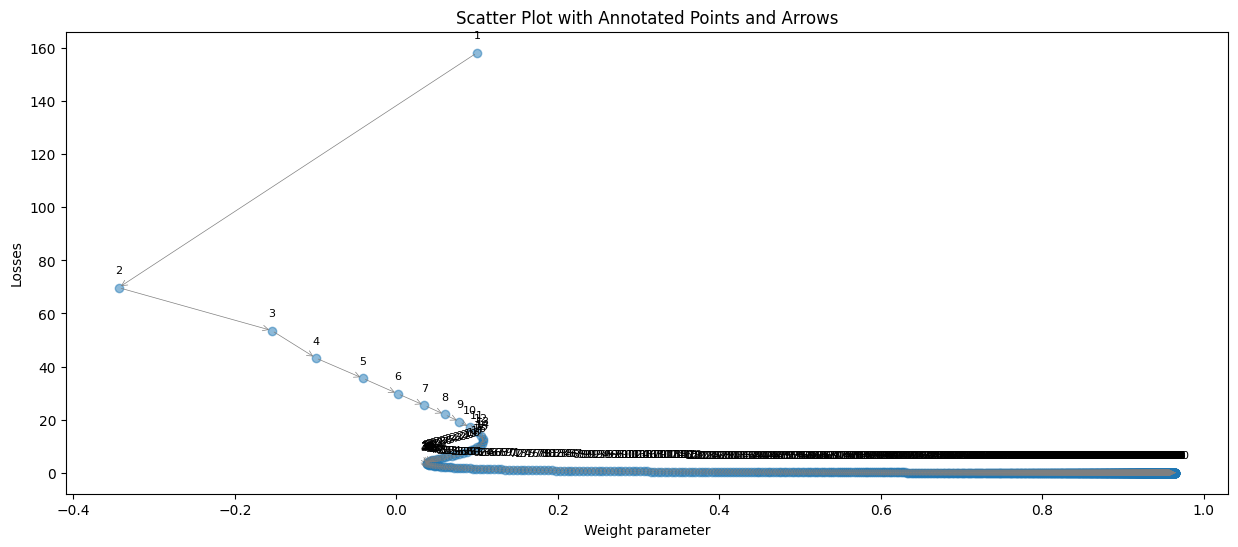

In [117]:
# Define the size of the figure
plt.figure(figsize=(15, 6))  # Adjust the size as needed

# Create a scatter plot
plt.scatter(param, losses, alpha=0.5)  # Semi-transparent for all points

# Annotate each point with its index and connect them with arrows
for i, (param_val, loss_val) in enumerate(zip(param, losses)):
    plt.annotate(str(i+1),
                 (param_val, loss_val),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=8)
    # Draw arrows if it's not the last point
    if i < len(param) - 1:
        plt.annotate('',
                     xy=(param[i+1], losses[i+1]),  # End point for arrow (next point)
                     xytext=(param_val, loss_val),  # Start point for arrow (current point)
                     arrowprops=dict(arrowstyle="->", color='gray', lw=0.5),
                     va='center')

# Enhance the plot
plt.xlabel('Weight parameter')
plt.ylabel('Losses')
plt.title('Scatter Plot with Annotated Points and Arrows')
plt.show()


## Excercise

Enhance this example by constructing a synthetic dataset that incorporates two input features, and then determine the optimal model parameters using the numerical (GD) method.